2 Doc2Vec and LSTM

2.1. Train Doc2Vec Model

- We will now prepare the data for the Doc2Vec model. This involves tokenizing each headline (converting the text into individual words) and tagging each document (headline) for training.
- The Doc2Vec model will be trained to create vector representations (embeddings) for each headline.


In [1]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Prepare tagged data for Doc2Vec
tagged_data = [TaggedDocument(words=word_tokenize(doc.lower()), tags=[str(i)]) for i, doc in enumerate(X_train)]

# Train the Doc2Vec model
doc2vec_model = Doc2Vec(vector_size=100, window=5, min_count=1, epochs=20)
doc2vec_model.build_vocab(tagged_data)
doc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

# Generate embeddings for train, validation, and test sets
X_train_embed = np.array([doc2vec_model.infer_vector(word_tokenize(doc.lower())) for doc in X_train])
X_val_embed = np.array([doc2vec_model.infer_vector(word_tokenize(doc.lower())) for doc in X_val])
X_test_embed = np.array([doc2vec_model.infer_vector(word_tokenize(doc.lower())) for doc in X_test])


NameError: name 'X_train' is not defined

2.2. Reshape Data for LSTM Input

The generated embeddings are reshaped to fit the input requirements of the LSTM model.


In [16]:
# Reshape embeddings for LSTM input
X_train_embed = X_train_embed.reshape((X_train_embed.shape[0], X_train_embed.shape[1], 1))
X_val_embed = X_val_embed.reshape((X_val_embed.shape[0], X_val_embed.shape[1], 1))
X_test_embed = X_test_embed.reshape((X_test_embed.shape[0], X_test_embed.shape[1], 1))


2.3. Build and Train LSTM Model

We define and compile an LSTM model, specifying the structure and loss function. The model is then trained on the training set with validation to monitor its performance.


In [43]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical

# Example: Load your data (ensure X_train_embed and y_train are defined)
# X_train_embed = ...  # Your feature matrix for training
# y_train = ...        # Your labels for training
# X_val_embed = ...    # Your feature matrix for validation
# y_val = ...          # Your labels for validation

# Ensure your input data is reshaped correctly for LSTM (samples, timesteps, features)
X_train_embed = X_train_embed.reshape((X_train_embed.shape[0], X_train_embed.shape[1], 1))
X_val_embed = X_val_embed.reshape((X_val_embed.shape[0], X_val_embed.shape[1], 1))

# One-hot encoding for the output labels
num_classes = len(set(y_train))  # Calculate the number of classes
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)

# Define the LSTM model
lstm_model = Sequential([
    LSTM(64, input_shape=(X_train_embed.shape[1], 1), return_sequences=True),
    LSTM(32),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')  # Use softmax for multi-class classification
])

# Compile the model
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = lstm_model.fit(X_train_embed, y_train_cat, validation_data=(X_val_embed, y_val_cat), epochs=10, batch_size=32)

# Optionally, print model summary
lstm_model.summary()


ModuleNotFoundError: No module named 'tensorflow.keras'

2.4. Evaluate LSTM Model

The evaluation step assesses the trained LSTM model on the test set, providing accuracy and loss metrics to gauge its performance.


In [19]:
test_loss, test_accuracy = lstm_model.evaluate(X_test_embed, to_categorical(y_test, num_classes))
print(f"LSTM Test accuracy: {test_accuracy:.4f}")
print(f"LSTM Test loss: {test_loss:.4f}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.6027 - loss: 0.8738
LSTM Test accuracy: 0.5899
LSTM Test loss: 0.8871


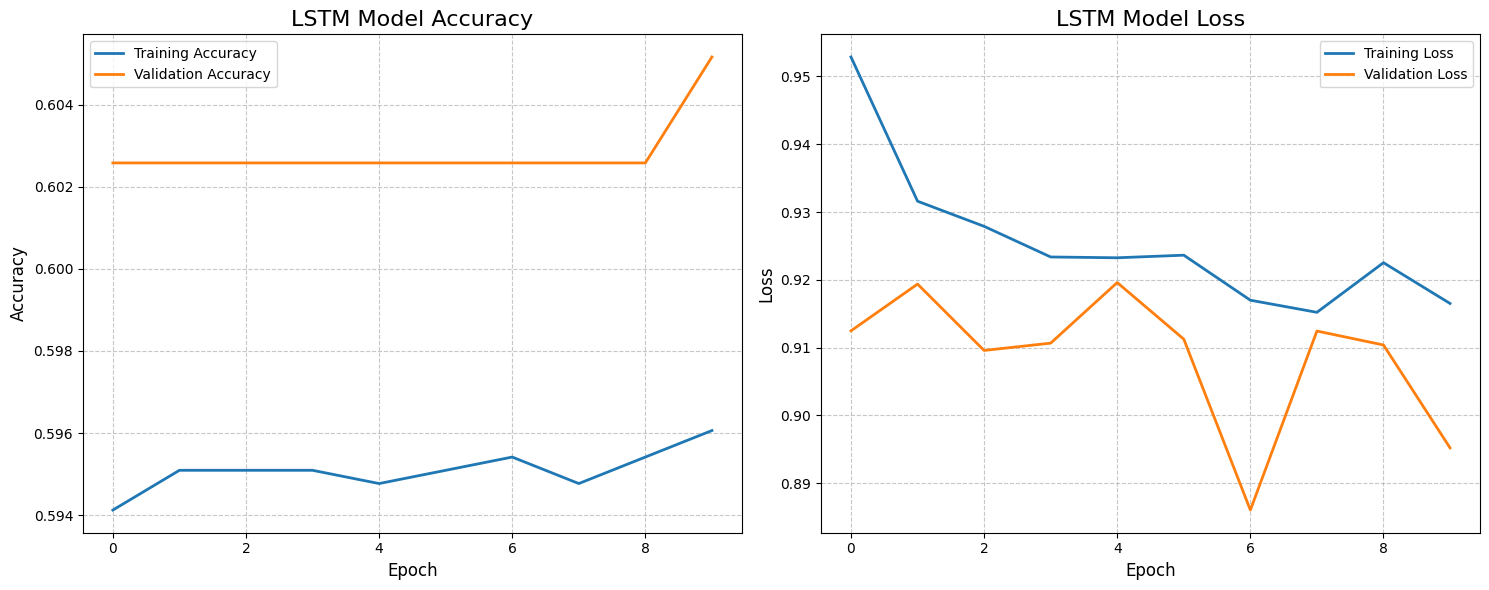

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('LSTM Model Accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('LSTM Model Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

The training and validation accuracy and loss plots help us visualize the model's performance over epochs. We look for trends such as convergence and any signs of overfitting.


3 LLM Approach: BERT

3.1 Tokenization

##### 3.1 Tokenization

 we utilize the BERT tokenizer to preprocess our datasets for the BERT model. Tokenization is an essential step in natural language processing (NLP), as it transforms raw text into a format that can be understood by the model.

1. We load the pre-trained BERT tokenizer using the `BertTokenizer` class from the `transformers` library. The `bert-base-uncased` model is used here, which is a lower-cased version of the BERT model, making it suitable for various NLP tasks.

2. We then tokenize our training, validation, and test datasets (`X_train`, `X_val`, and `X_test`). The tokenization process includes:
   - **Truncation**: Longer sentences are truncated to ensure they fit within the maximum length of 128 tokens.


In [21]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the datasets
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(X_val, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=128)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


3.2. Prepare Data for BERT

We create Tensor datasets for both the training and validation sets using `torch.utils.data.TensorDataset`. Each dataset consists of:
   - **Input IDs**: The tokenized representations of the input sentences (from `train_encodings['input_ids']` and `val_encodings['input_ids']`).
   - **Attention Masks**: A binary mask indicating which tokens should be attended to (from `train_encodings['attention_mask']` and `val_encodings['attention_mask']`).
   - **Labels**: The target labels for classification (stored in `y_train` for training and `y_val` for validation).

In [22]:
import torch

# Create Tensor datasets for training and validation
train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(train_encodings['input_ids']),
    torch.tensor(train_encodings['attention_mask']),
    torch.tensor(y_train)
)

val_dataset = torch.utils.data.TensorDataset(
    torch.tensor(val_encodings['input_ids']),
    torch.tensor(val_encodings['attention_mask']),
    torch.tensor(y_val)
)

In [23]:
#pip install torch

3.3. Build and Train BERT Model

 We define a custom dataset class to manage tokenized inputs and labels, then create training and validation datasets using the Hugging Face library.  We configure the training parameters, including batch sizes and epochs, and create a `Trainer` instance to facilitate the training process. Finally, we initiate the training with `trainer.train()`, allowing the model to learn from the dataset.


In [24]:
!pip install datasets

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.4 MB/s eta 0:00:00


In [ ]:
import torch
from torch.utils.data import Dataset
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset as HFDataset



class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = HFDataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': y_train
})
val_dataset = HFDataset.from_dict({
    'input_ids': val_encodings['input_ids'],
    'attention_mask': val_encodings['attention_mask'],
    'labels': y_val
})

# Define device (GPU if available, otherwise use CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained DistilBERT model
bert_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_classes)
bert_model.to(device)  # Move model to GPU if available

# Define training arguments with optimized settings
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    load_best_model_at_end=True,
    evaluation_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    save_steps=500,
    save_total_limit=2,
    metric_for_best_model="loss",
    greater_is_better=False,
    dataloader_num_workers=2,
    gradient_accumulation_steps=4,
)

# Create a Trainer instance
trainer = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# Train the model
trainer.train()

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

3.4. Evaluate BERT Model

In [ ]:
# Convert the test data to a HuggingFace Dataset
test_dataset = HFDataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'labels': y_test
})

# Evaluate BERT model on the test set
bert_predictions = trainer.predict(test_dataset)
bert_predictions = np.argmax(bert_predictions.predictions, axis=1)

# accuracy
bert_accuracy = np.mean(bert_predictions == y_test)
print(f"BERT Test accuracy: {bert_accuracy:.4f}")


4 Comparison of Models

4.1 Generate Classification Reports

In [ ]:
from sklearn.metrics import classification_report

# Get predictions from the LSTM model
lstm_predictions = np.argmax(lstm_model.predict(X_test_embed), axis=1)

print("LSTM Classification Report:")
print(classification_report(y_test, lstm_predictions, target_names=label_encoder.classes_))

print("\nBERT Classification Report:")
print(classification_report(y_test, bert_predictions, target_names=label_encoder.classes_))


4.2. Visualize Confusion Matrices

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrices
plt.figure(figsize=(12, 5))

# LSTM Confusion Matrix
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, lstm_predictions), annot=True, fmt='d', cmap='Blues')
plt.title('LSTM Confusion Matrix', fontsize=14)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)

# BERT Confusion Matrix
plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test, bert_predictions), annot=True, fmt='d', cmap='Blues')
plt.title('BERT Confusion Matrix', fontsize=14)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)

plt.tight_layout()
plt.show()

4.3 Testing the LSTM Model on Custom Text

In [ ]:
def test_lstm_model(text, model, doc2vec_model, label_encoder):
    tokens = word_tokenize(text.lower())
    embedding = doc2vec_model.infer_vector(tokens).reshape(1, -1, 1)

    prediction = model.predict(embedding)
    predicted_class = np.argmax(prediction)

    predicted_sentiment = label_encoder.inverse_transform([predicted_class])

    return predicted_sentiment[0]

custom_text = "The company has reported strong growth in the past quarter."
predicted_sentiment = test_lstm_model(custom_text, lstm_model, doc2vec_model, label_encoder)
print(f"LSTM Model predicted sentiment: {predicted_sentiment}")


4.4 Testing the BERT Model on Custom Text

In [ ]:
from transformers import BertTokenizer
import torch

def test_bert_model(text, model, tokenizer, label_encoder):
    encoding = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=1).item()

    predicted_sentiment = label_encoder.inverse_transform([predicted_class])

    return predicted_sentiment[0]

custom_text_bert = "The company has launched an innovative product that has received great feedback."
predicted_sentiment_bert = test_bert_model(custom_text_bert, bert_model, tokenizer, label_encoder)
print(f"BERT Model predicted sentiment: {predicted_sentiment_bert}")


> it is clear that BERT is significantly outperforming the LSTM model in terms of precision, recall, f1-score, and overall accuracy.